In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import efc_2dm as efc
import adefc_vortex.fresnel_2dm_96 as fresnel
import adefc_vortex.fraunhofer_2dm_96 as fraunhofer

Nwaves = 15
wavelength_c = 650e-9
bw = 0.10
waves = np.linspace(wavelength_c * (1-bw/2), wavelength_c * (1+bw/2), Nwaves )
bandpasses = waves.reshape(3,5)
print(bandpasses)

Nwaves_per_bp = bandpasses.shape[1]
control_waves = bandpasses[:, Nwaves_per_bp//2]
print(control_waves)

dm1_flat = xp.rot90(xp.rot90( utils.load_fits('data/dm1_flat_command.fits') ))

/home/kianmilani/Projects/adefc-vortex/adefc_vortex
[[6.17500000e-07 6.22142857e-07 6.26785714e-07 6.31428571e-07
  6.36071429e-07]
 [6.40714286e-07 6.45357143e-07 6.50000000e-07 6.54642857e-07
  6.59285714e-07]
 [6.63928571e-07 6.68571429e-07 6.73214286e-07 6.77857143e-07
  6.82500000e-07]]
[6.26785714e-07 6.50000000e-07 6.73214286e-07]


In [24]:
47000/100

470.0

/home/kianmilani/Projects/adefc-vortex/adefc_vortex


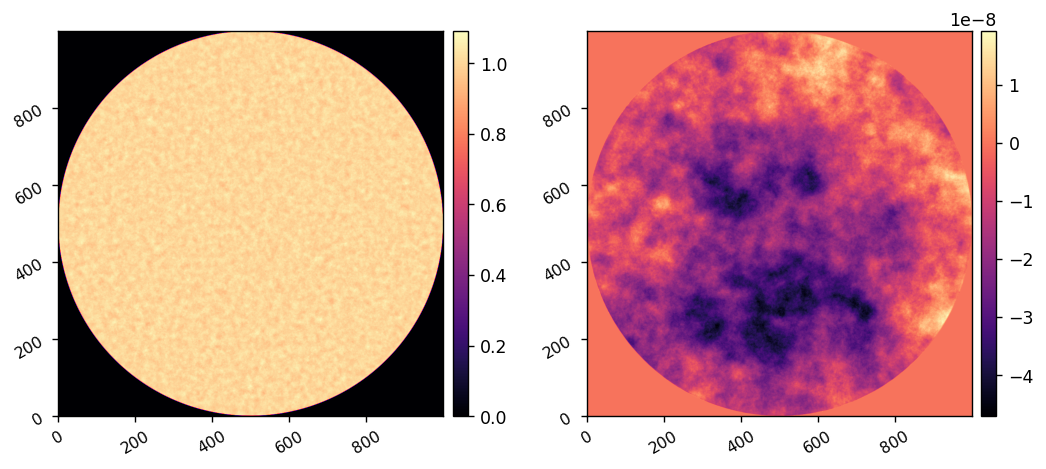

In [3]:
reload(fresnel)
I = fresnel.CORO(
    dm1_gains=1 + 0.02*xp.random.randn(96,96),
    dm2_gains=1 + 0.02*xp.random.randn(96,96),
    inf_fun_coupling=0.17,
    dm1_shift=np.array([75, 75 ])*u.um,
    dm2_shift=np.array([-75, -75 ])*u.um,
    lyot_shift=np.array([-75, 75 ])*u.um,
    # dm1_ref=dm1_flat,
)
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

In [17]:
9.6e-3**2/(4*650e-9*280e-3)

126.59340659340656

In [20]:
47e-3**2/(4*650e-9*700e-3), 47e-3**2/(4*650e-9*280e-3)

(1213.7362637362637, 3034.340659340659)

/home/kianmilani/Projects/adefc-vortex/adefc_vortex


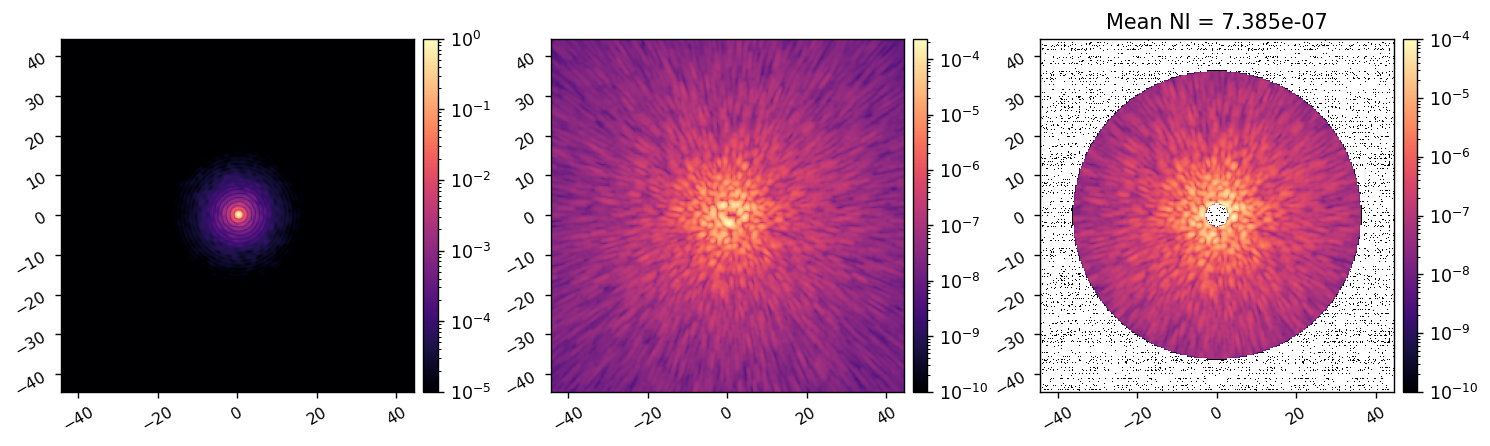

In [8]:
reload(fresnel)
# I = fresnel.CORO(
#     # dm1_ref=dm1_flat,
# )
# I = fresnel.CORO(
#     dm1_gains=1 + 0.02*xp.random.randn(96,96),
#     dm2_gains=1 + 0.02*xp.random.randn(96,96),
#     inf_fun_coupling=0.17,
#     dm1_shift=np.array([100, 25 ])*u.um,
#     dm2_shift=np.array([-25, -100 ])*u.um,
#     lyot_shift=np.array([-50, -50 ])*u.um,
#     # dm1_ref=dm1_flat,
# )
I = fresnel.CORO(
    dm1_gains=1 + 0.02*xp.random.randn(96,96),
    dm2_gains=1 + 0.02*xp.random.randn(96,96),
    inf_fun_coupling=0.17,
    dm1_shift=np.array([75, 75 ])*u.um,
    dm2_shift=np.array([-75, -75 ])*u.um,
    lyot_shift=np.array([-75, 75 ])*u.um,
    # dm1_ref=dm1_flat,
)
I.use_opds = True
I.bandpasses = bandpasses 

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

reload(utils)
I.reset_dms()
iwa = 3
owa = 36
rot = 0
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=None, rotation=rot)
# control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=iwa, rotation=rot)
mean_ni0 = xp.mean(ref_coro_im[control_mask])

imshow3(
    ref_psf, ref_coro_im, ref_coro_im*control_mask,
    '', '', f'Mean NI = {mean_ni0:.3e}',
    pxscl=I.psf_pixelscale_lamDc, 
    lognorm=True, vmin1=1e-5, vmin2=1e-10, vmin3=1e-10,
)

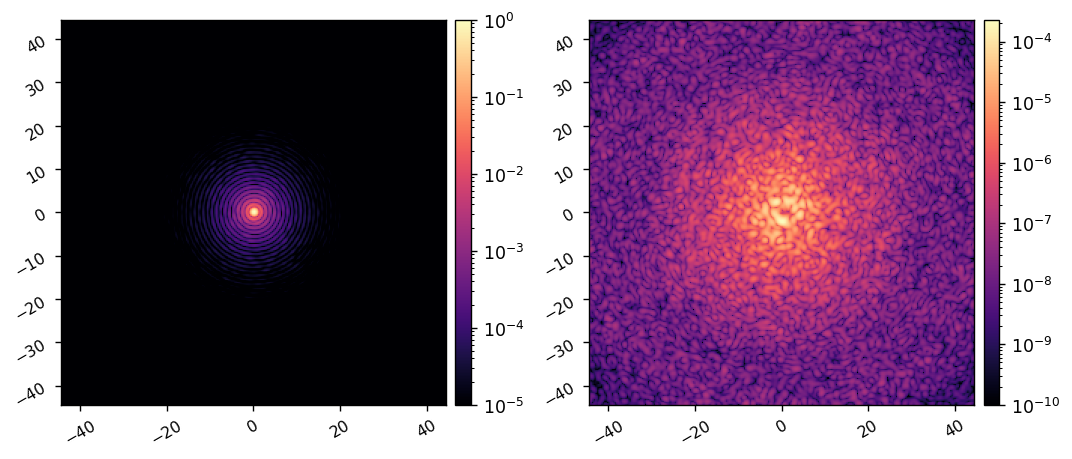

In [4]:
reload(fraunhofer)
M = fraunhofer.MODEL()
# M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

acts = xp.zeros(M.Nacts)

model_psf = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=0) )**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

model_coro_im = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=1) )**2

imshow2(model_psf, model_coro_im,
        pxscl=M.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)

In [ ]:
reload(efc)
jac = efc.compute_jacobian_bb(
    M, 
    control_mask, 
    control_waves, 
    amp=1e-9, 
    # current_acts=current_acts,
)


(201432, 14736)
(67144, 14736)
(67144, 14736)de 14736/14736 in 1571.285s
(67144, 14736)de 14736/14736 in 1571.792s


In [5]:
201432*14736*8/1e9

23.746415616

In [9]:
utils.save_pickle('/npool/nvme/kianmilani/aefc-vortex-data/jac_bb_96.pkl', jac)

Saved data to:  /npool/nvme/kianmilani/aefc-vortex-data/jac_bb_96.pkl


In [5]:
jac = utils.load_pickle('/npool/nvme/kianmilani/aefc-vortex-data/jac_bb_96.pkl')

In [47]:
I.reset_dms()
data = {
    'images':[ref_coro_im],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

In [122]:
beta = -1
control_matrix = utils.beta_reg(jac, beta)

In [27]:
utils.save_pickle(f'/npool/nvme/kianmilani/aefc-vortex-data/cm_bb_96_{beta:.1f}.pkl', control_matrix)

Saved data to:  /npool/nvme/kianmilani/aefc-vortex-data/cm_bb_96_-3.0.pkl


In [121]:
import gc
del(control_matrix)
gc.collect()

65291

In [115]:
data = utils.load_pickle(f'/npool/nvme/kianmilani/aefc-vortex-data/{today}_efc_run_with_ME.pkl')
I.set_dm1(data['dm1_commands'][-1])
I.set_dm2(data['dm2_commands'][-1])

In [116]:
data['reg_conds']

[-1.5, -1.5, -1.5, -3, -3, -3, -1, -1, -1, -3, -3, -3, -1, -1, -1]

Computing E-field with model ...
0


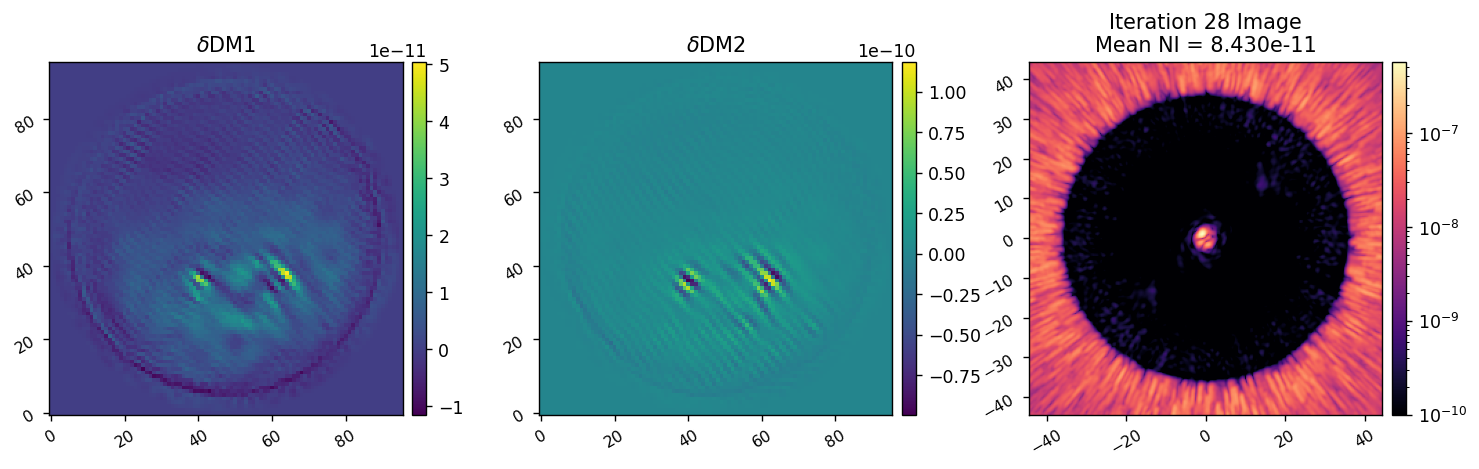

Computing E-field with model ...
1


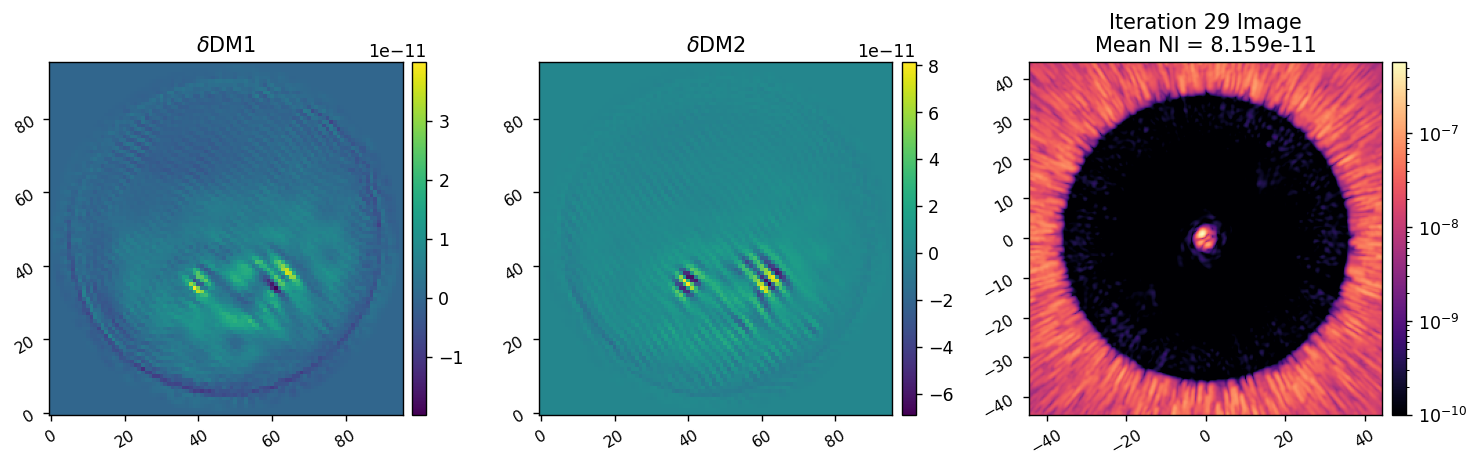

Computing E-field with model ...
2


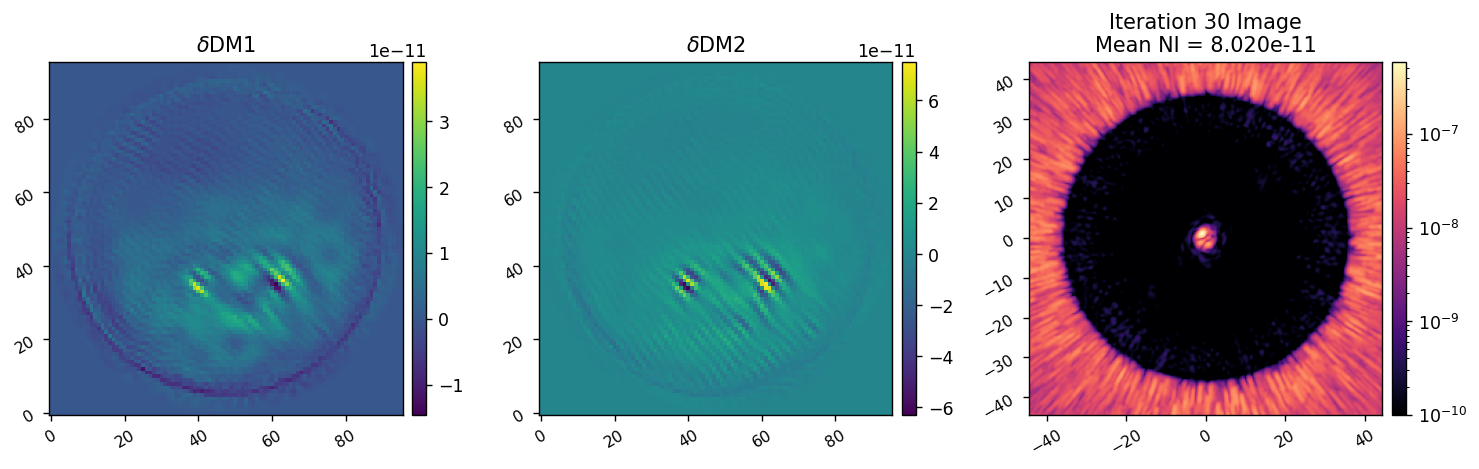

In [125]:
reload(fraunhofer)
reload(efc)

data = efc.run_bb(
    I, 
    control_matrix,
    beta,
    control_mask, 
    control_waves,
    data,
    Nitr=3, 
    gain=1,
)


In [126]:
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
utils.save_pickle(f'/npool/nvme/kianmilani/aefc-vortex-data/{today}_efc_run_with_ME_2.pkl', data)

Saved data to:  /npool/nvme/kianmilani/aefc-vortex-data/20241220_efc_run_with_ME_2.pkl


In [127]:
data['reg_conds']

[-1.5,
 -1.5,
 -1.5,
 -3,
 -3,
 -3,
 -1,
 -1,
 -1,
 -3,
 -3,
 -3,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -2.5,
 -2.5,
 -2.5,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

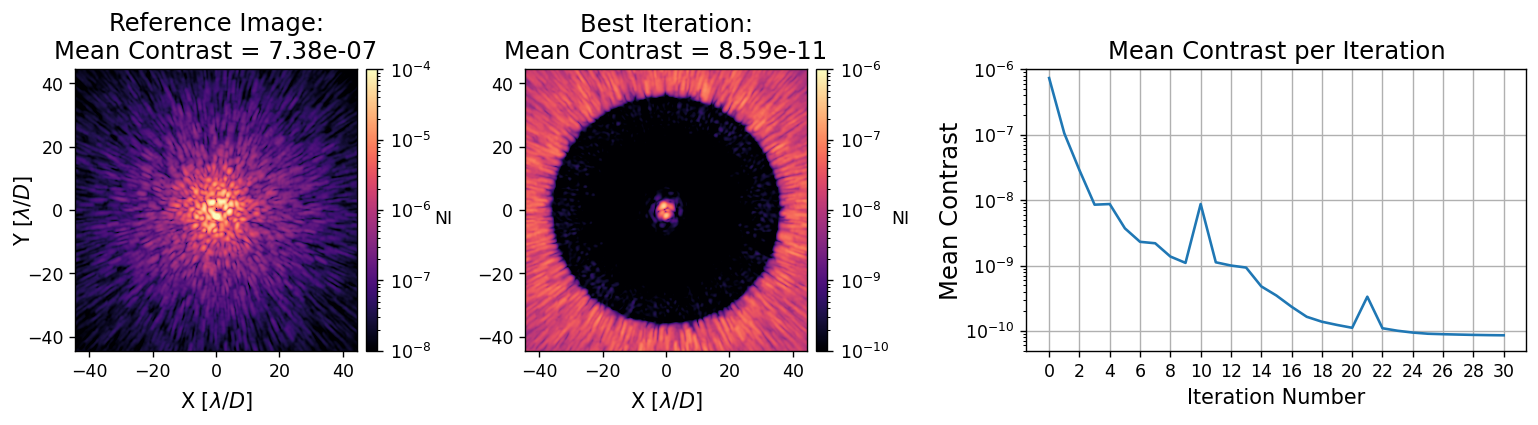

In [ ]:
import adefc_vortex.imshows as imshows
reload(imshows)
imshows.plot_data(
    data, 
    imvmin=1e-10, imvmax=1e-6,
    vmin=5e-11, vmax=1e-6,
)

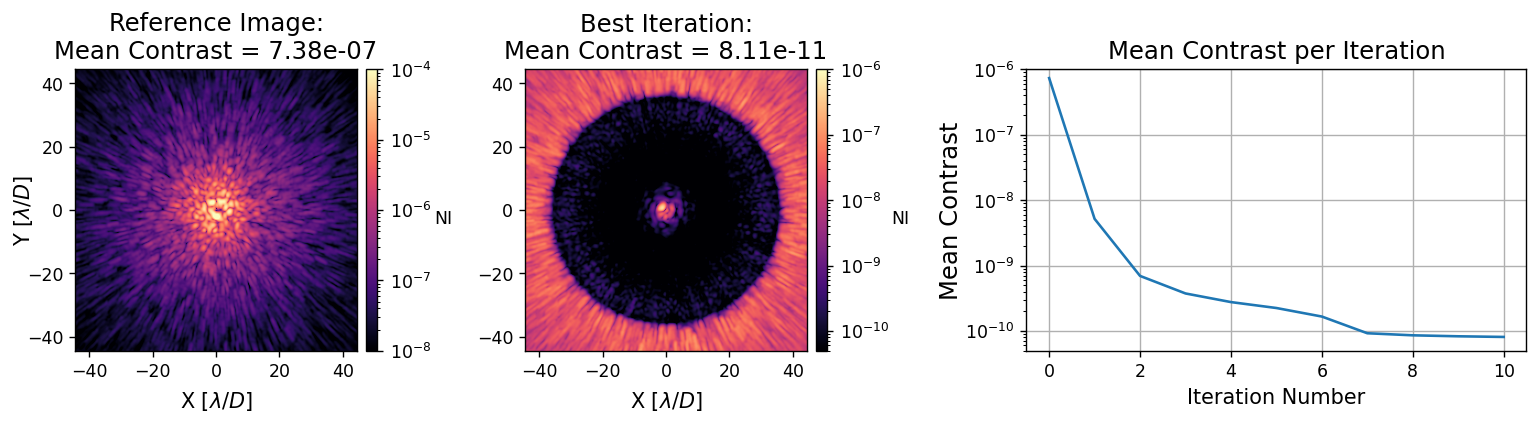

In [51]:
import adefc_vortex.imshows as imshows
reload(imshows)
imshows.plot_data(
    data, 
    im1vmin=1e-8, im1vmax=1e-4, 
    im2vmin=5e-11, im2vmax=1e-6,
    vmin=5e-11, vmax=1e-6,
)